In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# 1. Load and normalize CIFAR10

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:25<00:00, 6805013.19it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


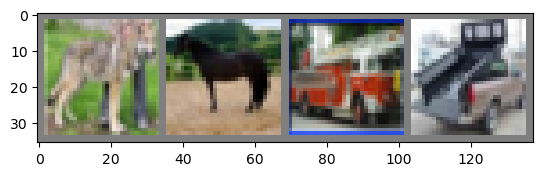

dog   horse truck truck


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 2. Define a Convolutional Neural Network

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# 3. Define a Loss function and optimizer

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
# 4. Train the network

In [25]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.051
[1,  4000] loss: 1.067
[1,  6000] loss: 1.072
[1,  8000] loss: 1.058
[1, 10000] loss: 1.065
[1, 12000] loss: 1.057
[2,  2000] loss: 0.981
[2,  4000] loss: 1.006
[2,  6000] loss: 0.996
[2,  8000] loss: 1.010
[2, 10000] loss: 1.012
[2, 12000] loss: 1.014
Finished Training


In [26]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 5. Test the network on the test data

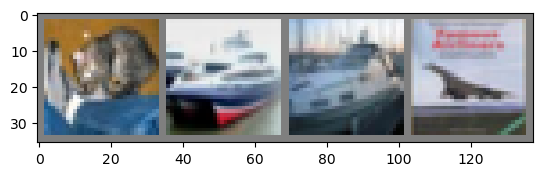

GroundTruth:  cat   ship  ship  plane


In [29]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [30]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [31]:
outputs = net(images)

In [33]:
_, predicted = torch.max(outputs, 1)
print(outputs)
print(predicted)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

tensor([[-0.6808, -1.3035, -0.2314,  4.1706, -0.3159,  2.9018, -0.9331, -0.3791,
         -1.1305, -2.6657],
        [ 5.6752,  7.2099, -1.5735, -3.6277, -4.6364, -4.8886, -3.3909, -5.6718,
          6.3764,  3.4219],
        [ 1.7363,  3.1938, -0.6231, -0.9088, -2.4602, -1.7987, -2.3341, -1.9130,
          1.8001,  2.2238],
        [ 7.0106, -0.1216,  3.6984, -2.4079, -0.2848, -5.5681, -3.0504, -3.6438,
          3.3987,  0.1101]], grad_fn=<AddmmBackward0>)
tensor([3, 1, 1, 0])
Predicted:  cat   car   car   plane


In [34]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


In [35]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 70.8 %
Accuracy for class: car   is 77.9 %
Accuracy for class: bird  is 50.3 %
Accuracy for class: cat   is 56.7 %
Accuracy for class: deer  is 57.2 %
Accuracy for class: dog   is 48.6 %
Accuracy for class: frog  is 65.8 %
Accuracy for class: horse is 55.3 %
Accuracy for class: ship  is 70.0 %
Accuracy for class: truck is 67.3 %
